

# Libraries and Dependencies

In [ ]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import shap
import os
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
import xgboost as xgb
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.inspection import PartialDependenceDisplay
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

In [ ]:
# Run this code to import the dataset from Kaggle

import kagglehub

# Download latest version
path = kagglehub.dataset_download("bhanupratapbiswas/uber-data-analysis")


uberDataset = pd.read_csv(os.path.join(path, "UberDataset.csv"))
# path points to the directory, os.path.join correctly combines the directory and filename
uberDataset.head()

100%|██████████| 17.1k/17.1k [00:00<00:00, 5.74MB/s]

Extracting files...


,START_DATE,END_DATE,CATEGORY,START,STOP,MILES,PURPOSE
0,01-01-2016 21:11,01-01-2016 21:17,Business,Fort Pierce,Fort Pierce,5.1,Meal/Entertain
1,01-02-2016 01:25,01-02-2016 01:37,Business,Fort Pierce,Fort Pierce,5.0,NaN
2,01-02-2016 20:25,01-02-2016 20:38,Business,Fort Pierce,Fort Pierce,4.8,Errand/Supplies
3,01-05-2016 17:31,01-05-2016 17:45,Business,Fort Pierce,Fort Pierce,4.7,Meeting
4,01-06-2016 14:42,01-06-2016 15:49,Business,Fort Pierce,West Palm Beach,63.7,Customer Visit


# **Part 1: Data Understanding and Exploration**

1. **Dataset Overview**




The Uber Data Analysis dataset is sourced from Kaggle and represents trip data from Uber. It contains
details about individual Uber trips, capturing information such as trip start and end times, distances,
locations, and purposes.

Context and Problem Domain: The dataset primarily explores patterns in transportation behavior and trip
purposes within Uber's ecosystem. It provides insights into urban mobility, specifically focusing on
ride-sharing patterns for personal and business use. This data could help analyze user demand patterns, peak
times for business vs. leisure travel, and the geographic trends in trip origins and destinations.




2. **Feature Description**



1.   START_DATE:

*   Type: Categorical (DateTime string format).
*   Significance: Records the start time of each trip, which helps analyze time-based patterns like peak hours or seasonal trends.


---


2. END_DATE

*   Type: Categorical (DateTime string format).
*   Significance: Indicates when each trip ended, allowing us to calculate trip durations if needed.


---


3. CATEGORY:

*   Type: Categorical.
*   Significance: Specifies whether the trip was for “Business” or another purpose. Understanding the category can help distinguish travel behaviors between personal and business trips.


---


4. START:

*   Type: Categorical.
*   Significance: The starting location of the trip, valuable for analyzing geographic patterns in ride requests and identifying popular origin points.


---


5. STOP:

*   Type: Categorical.
*   Significance: The destination of the trip, which complements the START feature for route analysis and common destination identification.


---


6. MILES:

*   Type: Numerical (Float).
*   Significance: Indicates the distance traveled in each trip. This feature is useful for analyzing trip lengths and, combined with other features, may help estimate trip durations or identify trends in travel distances.


---


7. PURPOSE:

*   Type: Categorical.
*   Significance: Describes the purpose of the trip (e.g., "Meeting," "Errand/Supplies"). This can offer insights into travel behavior.



---



There’s no explicit target variable, but we could define one based on the analysis goals. For instance, if predicting trip distance, MILES could be a target, or if analyzing business vs. personal trip behavior, CATEGORY might be treated as a target.



















3. **Dataset Structure**

In [ ]:
uberDataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1156 entries, 0 to 1155
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   START_DATE  1156 non-null   object 
 1   END_DATE    1155 non-null   object 
 2   CATEGORY    1155 non-null   object 
 3   START       1155 non-null   object 
 4   STOP        1155 non-null   object 
 5   MILES       1156 non-null   float64
 6   PURPOSE     653 non-null    object 
dtypes: float64(1), object(6)
memory usage: 63.3+ KB




*   Number of Rows: 1,156
*   Number of Columns: 7


The dataset does not have a hierarchical structure; each row represents an individual Uber trip with associated details like start and end times, locations, and distance traveled.



4. **Missing Values and Duplicates**

In [ ]:
missing_values = uberDataset.isnull().sum()
print(missing_values)

START_DATE      0
END_DATE        1
CATEGORY        1
START           1
STOP            1
MILES           0
PURPOSE       503
dtype: int64


Missing Values:

*   END_DATE has 1 missing value.
*   CATEGORY has 1 missing value.

*   START and STOP each have 1 missing value.
*   PURPOSE has a substantial number of missing values (503 out of 1,156 entries).


---
Missing values in columns like END_DATE and PURPOSE might affect the analysis, especially for calculating trip durations or understanding trip purposes. The missing data will need to be handled carefully based on the analysis goals.







In [ ]:
 # Number of duplicates present in the dataset
duplicate_values = uberDataset.duplicated().sum()
print(f"There is {duplicate_values} duplicate values in the dataset")

# Display the duplicates along with the original rows
uberDataset[uberDataset.duplicated(keep=False)]

There is 1 duplicate values in the dataset


,START_DATE,END_DATE,CATEGORY,START,STOP,MILES,PURPOSE
491,6/28/2016 23:34,6/28/2016 23:59,Business,Durham,Cary,9.9,Meeting
492,6/28/2016 23:34,6/28/2016 23:59,Business,Durham,Cary,9.9,Meeting


Duplicates:

*   There is 1 duplicate row in the dataset. The duplicated trip records a "Business" trip on 6/28/2016 from Durham to Cary, covering 9.9 miles with a "Meeting" purpose.


---

Duplicates could introduce bias, especially in aggregate analyses such as average trip distance or total trip count. Removing duplicates will help ensure data integrity, particularly for insights based on unique trips.





5. **Statistical Summary**

In [ ]:
statistical_summary = uberDataset.describe()
print(statistical_summary)

              MILES
count   1156.000000
mean      21.115398
std      359.299007
min        0.500000
25%        2.900000
50%        6.000000
75%       10.400000
max    12204.700000


Count: There are 1,156 recorded trips in the dataset.

Mean: The average trip distance is 21.12 miles, suggesting that while many trips are relatively short, a few very long trips skew the mean upward.

Standard Deviation: With a large standard deviation of 359.3 miles, trip distances show high variability, likely influenced by a few extreme values.

Minimum and Maximum: The shortest trip is 0.5 miles, while the longest is an exceptionally high 12,204.7 miles. This maximum value may indicate an outlier or data entry error.

Quartiles:

*   25th Percentile (Q1): 2.9 miles, meaning that 25% of trips are shorter than this distance.

*   Median (50th Percentile, Q2): 6.0 miles, showing that half of the trips are 6 miles or less.

*   75th Percentile (Q3): 10.4 miles, indicating that 75% of trips are shorter than this distance.


---
Most trips are relatively short, with 75% of trips under 10.4 miles. However, the very high maximum value suggests the presence of outliers, which could distort analyses relying on the mean distance. Investigating these extreme values will be essential to ensure they reflect accurate data.








6. **Data Distribution**

<ipython-input-8-17a3a7268e79>:4: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(uberDataset['MILES'], shade=True)


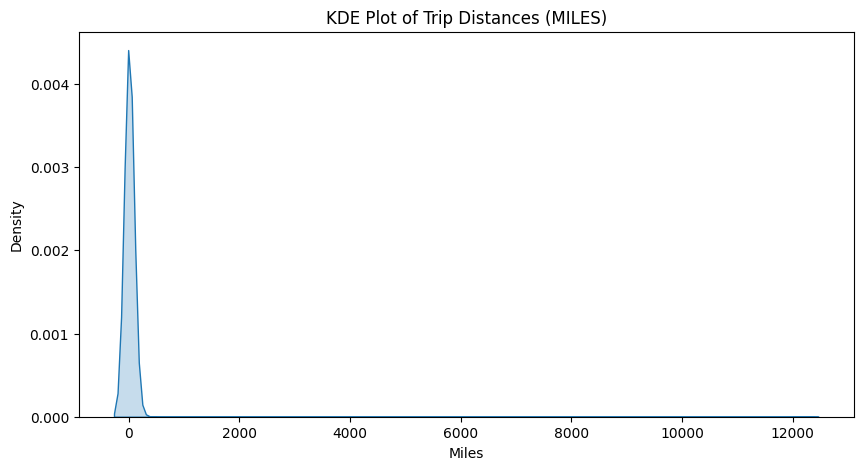

<Figure size 640x480 with 0 Axes>

In [ ]:
# Plotting Kernel Density Plot (KDE) for MILES
plt.figure(figsize=(10, 5))

sns.kdeplot(uberDataset['MILES'], shade=True)
plt.title('KDE Plot of Trip Distances (MILES)')
plt.xlabel('Miles')
plt.ylabel('Density')
plt.show()

# Show plot
plt.tight_layout()
plt.show()

The KDE plot shows that most Uber trips have very short distances, with a sharp peak near zero. There’s a long tail stretching to the right, indicating a few trips with extremely high mileage, which creates a right-skewed distribution. These outliers could significantly impact averages and may need further review.








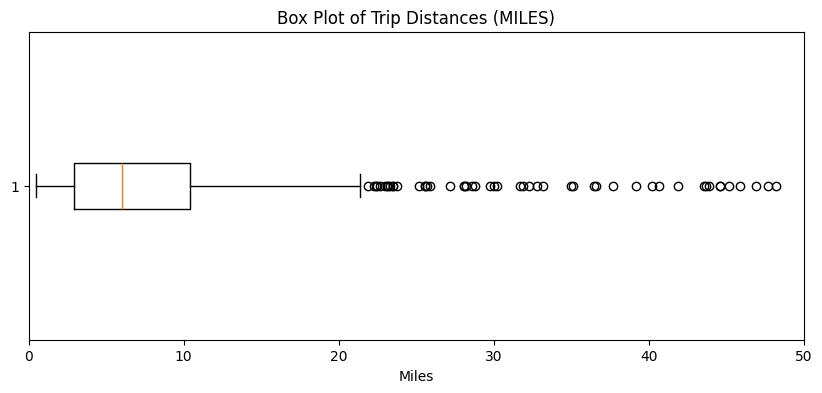

In [ ]:
# Box plot for MILES
plt.figure(figsize=(10, 4))
plt.boxplot(uberDataset['MILES'], vert=False)
plt.title('Box Plot of Trip Distances (MILES)')
plt.xlabel('Miles')
plt.xlim(0, 50)  # Adjust x-axis to focus on trips under 50 miles
plt.show()

The box plot shows that the majority of trips fall within a short distance range, with the box spanning approximately 2 to 10 miles. There are many outliers extending beyond 10 miles, shown as individual points. This confirms that while most trips are short, there are a significant number of longer trips, contributing to a right-skewed distribution.








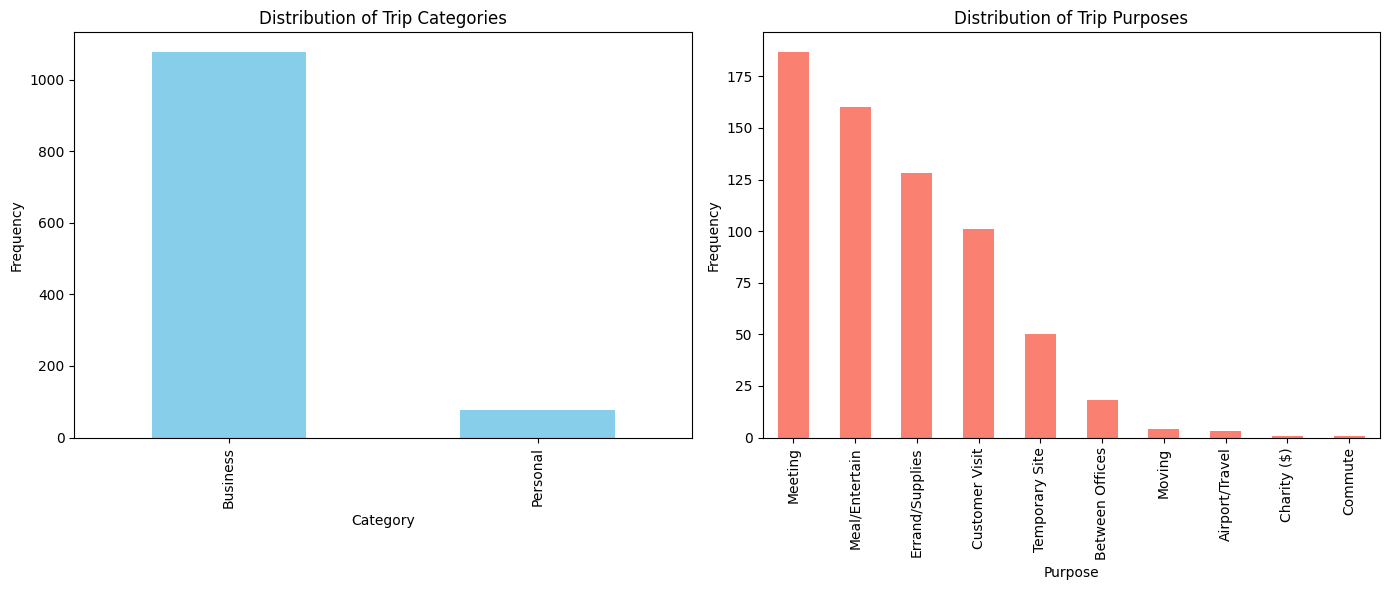

In [ ]:
# Create a figure with two subplots side by side
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Bar plot for CATEGORY
uberDataset['CATEGORY'].value_counts().plot(kind='bar', ax=axes[0], color='skyblue')
axes[0].set_title('Distribution of Trip Categories')
axes[0].set_xlabel('Category')
axes[0].set_ylabel('Frequency')

# Bar plot for PURPOSE
uberDataset['PURPOSE'].value_counts().plot(kind='bar', ax=axes[1], color='salmon')
axes[1].set_title('Distribution of Trip Purposes')
axes[1].set_xlabel('Purpose')
axes[1].set_ylabel('Frequency')

# Display the plots
plt.tight_layout()
plt.show()

CATEGORY: Most trips are labeled as "Business," with very few categorized as "Personal." This suggests that the dataset primarily consists of business-related trips.

PURPOSE: The most common purposes are "Meeting," "Meal/Entertain," and "Errand/Supplies." This indicates that the trips are frequently associated with business activities, including client meetings, meals, and running errands or gathering supplies.

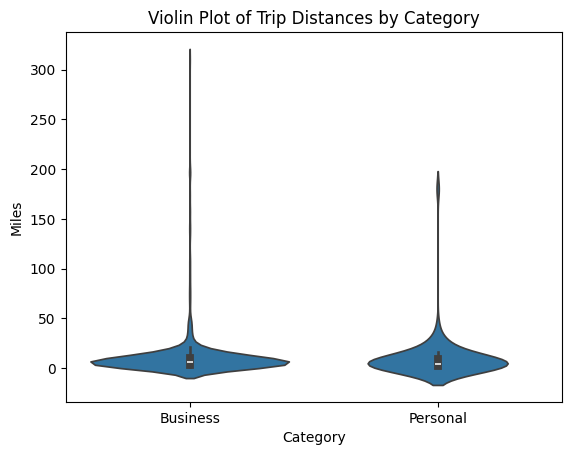

In [ ]:
 # Comparing distributions of MILES variable across Category
sns.violinplot(x='CATEGORY', y='MILES', data=uberDataset)
plt.title('Violin Plot of Trip Distances by Category')
plt.xlabel('Category')
plt.ylabel('Miles')
plt.show()


Both categories show a concentration of shorter trips, as seen by the wider sections near the lower end of the plot. This suggests that most trips, regardless of category, are short.

The long tails extending upward indicate that a few trips cover much greater distances, especially in the "Business" category. This tail implies that while most trips are short, there are some long-distance trips, more so for business.

7. **Correlation Analysis**

We will create a Duration column by calculating the difference between START_DATE and END_DATE.

This would give us a new numerical feature to analyze trip length in terms of time, which might correlate with MILES.

In [ ]:
# Convert to datetime format with mixed format handling
uberDataset['START_DATE'] = pd.to_datetime(uberDataset['START_DATE'], format='mixed', dayfirst=True, errors='coerce')
uberDataset['END_DATE'] = pd.to_datetime(uberDataset['END_DATE'], format='mixed', dayfirst=True, errors='coerce')

# Derive trip duration in minutes
uberDataset['DURATION'] = (uberDataset['END_DATE'] - uberDataset['START_DATE']).dt.total_seconds() / 60

In [ ]:
# Check for unparsed dates
print(uberDataset[['START_DATE', 'END_DATE']].isna().sum())
uberDataset.shape

START_DATE    1
END_DATE      1
dtype: int64


(1156, 8)

In [ ]:
# Drop rows with NaN values in START_DATE or END_DATE columns
uberDataset = uberDataset.dropna(subset=['START_DATE', 'END_DATE']).reset_index(drop=True)

# Verify the shape to confirm the row was dropped
uberDataset.shape

(1155, 8)

We will extract useful time-related features from START_DATE such as hour of day, day of the week, and month. These can capture patterns in distance based on time of travel.

In [ ]:
uberDataset['HOUR'] = uberDataset['START_DATE'].dt.hour
uberDataset['DAY_OF_WEEK'] = uberDataset['START_DATE'].dt.dayofweek  # Monday=0, Sunday=6
uberDataset['MONTH'] = uberDataset['START_DATE'].dt.month



*   For CATEGORY and PURPOSE, we will use one-hot encoding to capture the categorical nature without imposing an ordinal structure.

*   For START and STOP locations, frequency encoding is a good choice since it captures the popularity of locations without creating too many features.

More on that will be discussed in the upcoming section.



In [ ]:
# One-hot encoding for CATEGORY and PURPOSE
uberDataset = pd.get_dummies(uberDataset, columns=['CATEGORY', 'PURPOSE'], drop_first=True)

# Frequency encoding for START and STOP
start_freq = uberDataset['START'].value_counts().to_dict()
stop_freq = uberDataset['STOP'].value_counts().to_dict()
uberDataset['START_freq'] = uberDataset['START'].map(start_freq)
uberDataset['STOP_freq'] = uberDataset['STOP'].map(stop_freq)

# Drop original START and STOP columns after frequency encoding
uberDataset = uberDataset.drop(columns=['START', 'STOP'])


After dealing with the categorical columns, we can proceed with the correlation analysis and produce the heatmap.

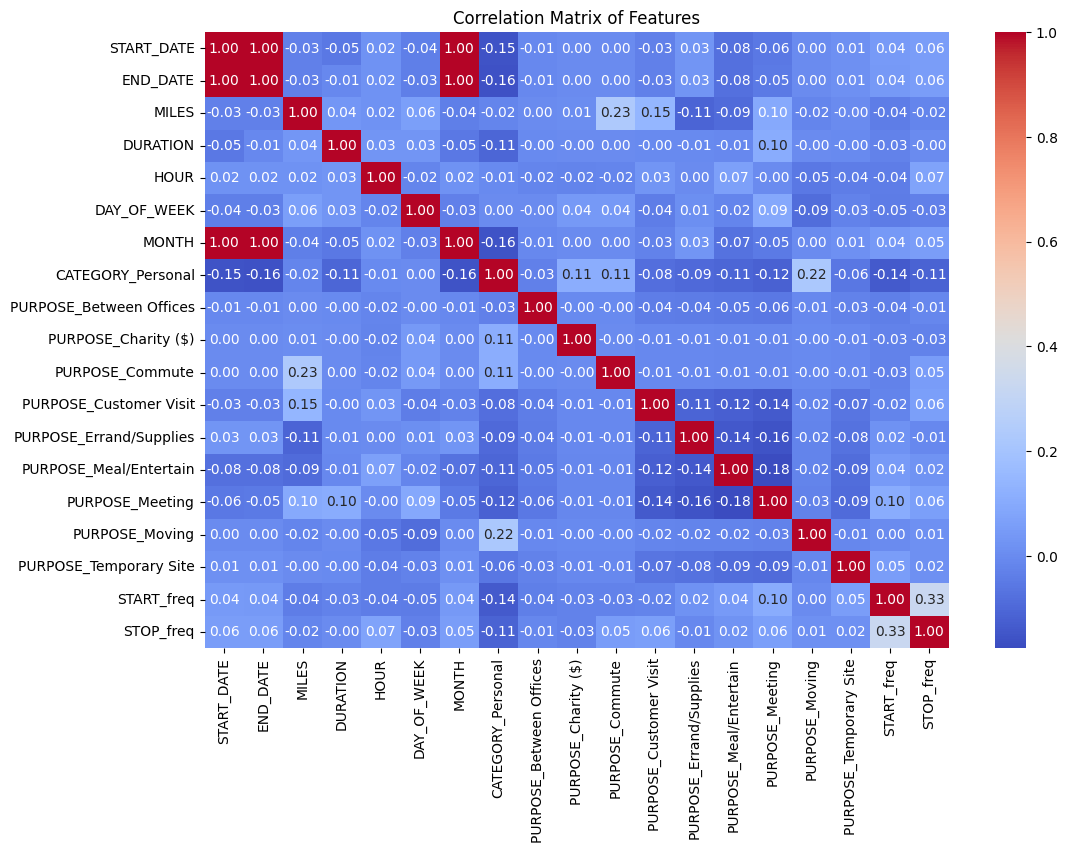

In [ ]:
# Calculate the correlation matrix
correlation_matrix = uberDataset.corr()

# Plot the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix of Features")
plt.show()

In [ ]:
# Display correlation values for MILES with each feature, sorted in descending order
miles_correlations = correlation_matrix["MILES"].sort_values(ascending=False)
print(miles_correlations)

MILES                      1.000000
PURPOSE_Commute            0.231506
PURPOSE_Customer Visit     0.145255
PURPOSE_Meeting            0.095379
DAY_OF_WEEK                0.058952
DURATION                   0.035060
HOUR                       0.019795
PURPOSE_Charity ($)        0.006187
PURPOSE_Between Offices    0.002203
PURPOSE_Temporary Site    -0.000916
CATEGORY_Personal         -0.015439
STOP_freq                 -0.015762
PURPOSE_Moving            -0.016444
END_DATE                  -0.030217
START_DATE                -0.031764
MONTH                     -0.036986
START_freq                -0.040515
PURPOSE_Meal/Entertain    -0.090514
PURPOSE_Errand/Supplies   -0.107992
Name: MILES, dtype: float64




*   PURPOSE_Commute (0.23) and PURPOSE_Customer Visit (0.15) have the highest positive correlations, indicating that commutes and customer visits tend to involve longer distances.

*   PURPOSE_Meeting (0.10) and DAY_OF_WEEK (0.06) have weak positive correlations, suggesting a slight influence on trip distance.

*   DURATION (0.04) has a surprisingly low correlation with MILES, implying that trip time and distance are not as strongly related as expected, possibly due to traffic or other factors.

*   PURPOSE_Errand/Supplies (-0.11) and PURPOSE_Meal/Entertain (-0.09) have the highest negative correlations, indicating these trips are generally shorter.

*   HOUR, CATEGORY_Personal, and frequency-encoded features (START_freq and STOP_freq) have near-zero correlations with MILES, suggesting they don’t significantly impact trip distance in a linear fashion.









8. **Outlier Detection**

For outlier detection in the MILES variable (target varialbe in our case), we can use the Interquartile Range (IQR) statistical method for detecting the outlier. For the visual inspection, it was already shown and interpreted in the previous sections.

In [ ]:
# Calculate Q1 (25th percentile) and Q3 (75th percentile)
Q1 = uberDataset['MILES'].quantile(0.25)
Q3 = uberDataset['MILES'].quantile(0.75)

# Calculate the Interquartile Range (IQR)
IQR = Q3 - Q1

# Calculate the lower and upper bounds for outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Calculate basic statistics
mean_miles = uberDataset['MILES'].mean()
median_miles = uberDataset['MILES'].median()
std_dev_miles = uberDataset['MILES'].std()

# Count the number of outliers
outliers = uberDataset[(uberDataset['MILES'] < lower_bound) | (uberDataset['MILES'] > upper_bound)]
num_outliers = outliers.shape[0]

# Print the results
print(f"Q1 (25th percentile): {Q1}")
print(f"Q3 (75th percentile): {Q3}")
print(f"IQR: {IQR}")
print(f"Lower bound for outliers: {lower_bound}")
print(f"Upper bound for outliers: {upper_bound}")
print(f"Mean of MILES: {mean_miles}")
print(f"Median of MILES: {median_miles}")
print(f"Standard Deviation of MILES: {std_dev_miles}")
print(f"Number of outliers in MILES: {num_outliers}")

Q1 (25th percentile): 2.9
Q3 (75th percentile): 10.4
IQR: 7.5
Lower bound for outliers: -8.35
Upper bound for outliers: 21.65
Mean of MILES: 10.566839826839827
Median of MILES: 6.0
Standard Deviation of MILES: 21.579105610060115
Number of outliers in MILES: 77


With 77 trips identified as outliers (distances exceeding 21.65 miles), these represent unusually long trips compared to the typical range (2.9 to 10.4 miles). The high number of outliers indicates that long-distance trips are not rare but still deviate from the typical trip distance.

Impact on Analysis:

*   Skewed Mean: The mean (10.57) is higher than the median (6.0), showing that these long trips pull the average upward, potentially skewing the data.

*   High Variability: The large standard deviation (21.58) reflects the influence of these outliers, which can lead to instability in models that are sensitive to data distribution, such as linear regression.

*   Modeling Challenges: Without addressing these outliers, predictions could be biased toward longer distances, especially for algorithms that rely on average values.








# **Part 2: Data Preprocessing**

9. **Handling Missing Data**

No additional imputation needed after one-hot encoding.

During one-hot encoding, missing values in PURPOSE were automatically represented as zeros across all PURPOSE categories, effectively labeling them as "Unknown" or "no specified purpose." This approach allowed us to retain these rows in the dataset while distinguishing trips without a specified purpose.

Since we plan on using tree-based models (e.g., random forest, XGBoost) then there is no need to handle the missing values from the MILES column because tree-based models are generally robust to outliers, meaning that the few extreme MILES values (77/1155) won’t skew predictions as much as they would in models like linear regression or neural networks.

10. **Encoding Categorical Variables**


One-Hot Encoding was used for CATEGORY and PURPOSE because:

These are non-ordinal variables (e.g., CATEGORY has "Business" and "Personal," and PURPOSE has multiple distinct categories).
One-hot encoding prevents the model from interpreting any order or ranking among these values, treating each as a unique, independent category.

Frequency Encoding was chosen for START and STOP locations because:

These columns have many unique values, which would result in too many columns if one-hot encoded.
Frequency encoding captures the popularity of each location while keeping the dataset compact and manageable.
This setup preserves category information while optimizing for model efficiency.

11. **Feature Scaling**

For now, since we are planning on using tree-based models, scaling is not necessary. Tree-based models split data based on threshold values and are not sensitive to feature scale, so scaling is not strictly required.

However, since we also plan on using neural networks to compare their performance with tree-based models, scaling would be recommended in this case. Neural networks are sensitive to feature scales, and unscaled data can lead to poor convergence. For neural networks, scaling all features (e.g., DURATION, HOUR, START_freq, STOP_freq) to a similar range (like 0 to 1 or standardized) improves performance.

12. **Feature Selection**

Selected Features: All available features will be included initially, as each contributes valuable information for predicting MILES.

Here’s the reasoning for each feature:

DURATION, HOUR, DAY_OF_WEEK, MONTH:
These time-based features are included because trip distance may vary by trip length (DURATION), time of day (HOUR), day of the week, and month. These attributes can capture patterns in travel distance across different times.

CATEGORY_Personal and PURPOSE columns:
One-hot encoded CATEGORY and PURPOSE columns add context for trip types, as trip distances could differ significantly based on whether a trip is for business, personal, or specific purposes like commuting or customer visits.

START_freq and STOP_freq:
Frequency-encoded START and STOP locations capture the popularity of each origin and destination. Popular routes may follow predictable distances, making these features valuable.

Feature Selection Methods:

All features are included initially to allow tree-based models and neural networks to evaluate their relevance.
Feature Importance Analysis: For tree-based models, feature importance scores will be examined to identify which features most impact the prediction. Based on this, less relevant features can be removed or further engineered in future iterations.

# **Part 3: Modeling**

13. **Algorithm Selection**

For predicting MILES (trip distance), we’re dealing with a regression problem. The following algorithms are well-suited for this task:

1. Tree-Based Models (e.g., Random Forest, XGBoost):

Tree-based models are highly effective for structured/tabular data and can handle non-linear relationships between features and the target variable. They’re also robust to outliers and don’t require strict data scaling.

Advantages:
Capture complex interactions between features automatically.
Perform well on medium-sized datasets, like this one, without extensive tuning.
Feature importance scores from tree-based models provide insights into the relative significance of each feature.

2. Linear Regression:

Linear regression is a straightforward model for understanding basic relationships between features and the target variable. It assumes a linear relationship, which may not capture complex patterns in trip distances but can serve as a baseline model.

Advantages:
Simple to interpret, providing insights into feature impact.
Useful as a baseline to compare against more complex models.

3. Neural Networks:

Neural networks can capture complex patterns in data and may perform well if non-linear interactions exist. However, they generally require more tuning, larger datasets, and normalized inputs.

Advantages:
Suitable for capturing complex patterns in the data.
Allows flexible architectures for further tuning, though they may need more computational resources.



14. **Data Splitting**

We will use the hold-out method combined with cross-validation for reliable evaluation.

Hold-Out Method:

Split the data into 80% training and 20% testing.
This ensures a substantial portion of data for training while preserving a separate set for unbiased model evaluation. The 80/20 split is a common ratio that balances model training and performance assessment.

Cross-Validation (on Training Data):

Apply k-fold cross-validation on the training set.
Cross-validation provides a robust measure of model performance, reducing variance in results by training and evaluating the model multiple times on different subsets. This helps prevent overfitting, as the model is tested on multiple data subsets, improving reliability.

15. **Model Training**

Each model will be trained on the training set (80% of the data) to predict MILES, using default hyperparameters from scikit-learn, XGBoost, and TensorFlow:

Random Forest: Default parameters with multiple trees to capture feature interactions.

XGBoost: Default parameters, building trees iteratively to reduce error.

Linear Regression: No hyperparameters; fits a line to minimize error.

Neural Network: A simple architecture with two hidden layers and 50 epochs.

16. **Model Evaluation**

Mean Absolute Error (MAE):

Measures the average absolute difference between predicted and actual values.

MAE provides a straightforward, interpretable metric showing how far predictions are, on average, from actual values.
It’s less sensitive to large errors, making it useful for assessing general accuracy in trip distance prediction.

Root Mean Squared Error (RMSE):

Calculates the square root of the average squared differences between predictions and actual values.

RMSE is more sensitive to large errors due to the squaring process, highlighting model performance on outliers or larger trips. This helps gauge how well the model handles both typical and extreme trip distances.

Both MAE and RMSE give a comprehensive view of model accuracy, with MAE indicating general performance and RMSE providing insight into error impact for larger distances.

**Data Splitting**

In [ ]:
# Define input features and target variable
X = uberDataset.drop(columns=['MILES', 'START_DATE', 'END_DATE'])  # Exclude datetime columns and target variable
# This ensures that only numerical and encoded categorical features are used as inputs for the model
y = uberDataset['MILES']

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

**Linear Regression**

In [ ]:
# Instantiate and train the Linear Regression model
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# Predict and evaluate
lr_predictions = lr_model.predict(X_test)
lr_mae = mean_absolute_error(y_test, lr_predictions)
lr_rmse = np.sqrt(mean_squared_error(y_test, lr_predictions))
print(f"Linear Regression MAE: {lr_mae}, RMSE: {lr_rmse}")


Linear Regression MAE: 8.948570932842344, RMSE: 23.96352056841555


**Neural Network**

In [ ]:
# Define and compile the Neural Network model
nn_model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    Dense(32, activation='relu'),
    Dense(1)  # Output layer
])

nn_model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
nn_model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2, verbose=1)

# Predict and evaluate
nn_predictions = nn_model.predict(X_test).flatten()
nn_mae = mean_absolute_error(y_test, nn_predictions)
nn_rmse = np.sqrt(mean_squared_error(y_test, nn_predictions))
print(f"Neural Network MAE: {nn_mae}, RMSE: {nn_rmse}")


Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 36936.8906 - val_loss: 922430.2500
Epoch 2/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2220.6418 - val_loss: 484247.9062
Epoch 3/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4195.4961 - val_loss: 17758.5215
Epoch 4/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1782.2987 - val_loss: 291737.8438
Epoch 5/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 3685.6445 - val_loss: 1613791.6250
Epoch 6/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 5493.0205 - val_loss: 2962202.0000
Epoch 7/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 88343.8125 - val_loss: 4527641.5000
Epoch 8/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4602.3521 - val_loss: 3465070.0000
Epoch 9/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1959.9783 - val_loss: 4472053.0000
Epoch 10/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 905.4023 - val_loss: 4981956.0000
Epoch 11/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 204.4209 - val_loss: 5228

**Random Forest**

In [ ]:
# Instantiate and train the Random Forest model
rf_model = RandomForestRegressor(random_state=42)
rf_model.fit(X_train, y_train)

# Predict and evaluate
rf_predictions = rf_model.predict(X_test)
rf_mae = mean_absolute_error(y_test, rf_predictions)
rf_rmse = np.sqrt(mean_squared_error(y_test, rf_predictions))
print(f"Random Forest MAE: {rf_mae}, RMSE: {rf_rmse}")


Random Forest MAE: 5.413078066378067, RMSE: 15.137719726234176


**XGBoost**

In [ ]:
# Instantiate and train the XGBoost model
xgb_model = XGBRegressor(random_state=42)
xgb_model.fit(X_train, y_train)

# Predict and evaluate
xgb_predictions = xgb_model.predict(X_test)
xgb_mae = mean_absolute_error(y_test, xgb_predictions)
xgb_rmse = np.sqrt(mean_squared_error(y_test, xgb_predictions))
print(f"XGBoost MAE: {xgb_mae}, RMSE: {xgb_rmse}")


XGBoost MAE: 5.424245848438956, RMSE: 16.865417878520322


17. **Performance Analysis**

Random Forest:

MAE: 5.41, RMSE: 15.14

Random Forest performs best overall, with the lowest MAE and RMSE, suggesting it captures patterns in the data more effectively than the other models.

XGBoost:

MAE: 5.42, RMSE: 16.87

XGBoost also performs well, with similar MAE but slightly higher RMSE compared to Random Forest. It indicates XGBoost is effective but may be slightly more sensitive to outliers or longer trips.

Neural Network:

MAE: 7.51, RMSE: 21.67

The neural network performs better than linear regression but lags behind Random Forest and XGBoost, likely due to the dataset size and complexity of tuning required for optimal performance.

Linear Regression:

MAE: 8.95, RMSE: 23.96

Linear regression shows the highest errors, indicating it struggles to capture complex relationships in the data, likely due to its assumption of linearity.





18. **Model Improvement**

Hyperparameter Tuning for Random Forest:

We will fine-tune Random Forest parameters to optimize performance. This can further improve accuracy by balancing tree depth and the number of trees.

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

# Define the parameter grid for GridSearchCV
param_grid = {
    'n_estimators': [100, 200, 300],        # Number of trees
    'max_depth': [None, 10, 20, 30],        # Depth of each tree
    'min_samples_split': [2, 5, 10],        # Minimum samples to split a node
    'min_samples_leaf': [1, 2, 4]           # Minimum samples required at each leaf node
}

# Initialize the Random Forest Regressor
rf = RandomForestRegressor(random_state=42)

# Set up GridSearchCV with 5-fold cross-validation
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, scoring='neg_mean_absolute_error', n_jobs=-1, verbose=2)

# Fit GridSearchCV on the training data
grid_search.fit(X_train, y_train)

# Get the best estimator and parameters
best_rf = grid_search.best_estimator_
best_params = grid_search.best_params_

print("Best parameters found: ", best_params)


Fitting 5 folds for each of 108 candidates, totalling 540 fits
Best parameters found:  {'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 300}


In [ ]:
# Make predictions on the test set using the tuned model
rf_test_preds = best_rf.predict(X_test)

# Calculate MAE and RMSE for the test set
rf_test_mae = mean_absolute_error(y_test, rf_test_preds)
rf_test_rmse = np.sqrt(mean_squared_error(y_test, rf_test_preds))

# Print the evaluation results
print(f"Tuned Random Forest MAE: {rf_test_mae}")
print(f"Tuned Random Forest RMSE: {rf_test_rmse}")

Tuned Random Forest MAE: 5.258145322010039
Tuned Random Forest RMSE: 14.738977000875707


Regularization and Scaling for XGBoost:

We will tune XGBoost regularization parameters (alpha, lambda) to reduce overfitting, as well as adjust subsample and colsample_bytree to improve generalization.

We will standardize continuous features to see if this improves XGBoost’s performance, as it can sometimes benefit from scaled inputs.

In [ ]:
# Select the continuous features to scale
continuous_features = ['DURATION', 'HOUR', 'START_freq', 'STOP_freq']

# Initialize a StandardScaler
scaler = StandardScaler()

# Apply scaling on training and testing sets
X_train[continuous_features] = scaler.fit_transform(X_train[continuous_features])
X_test[continuous_features] = scaler.transform(X_test[continuous_features])

In [ ]:
# Define the parameter grid with regularization
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.05, 0.1, 0.2],
    'max_depth': [3, 4, 5],
    'alpha': [0, 0.1, 1],      # L1 regularization term (Lasso)
    'lambda': [1, 1.5, 2]      # L2 regularization term (Ridge)
}

# Initialize the XGBoost regressor
xgb = XGBRegressor()

# Set up GridSearchCV with 5-fold cross-validation
grid_search_xgb = GridSearchCV(estimator=xgb, param_grid=param_grid, cv=5, scoring='neg_mean_absolute_error', n_jobs=-1, verbose=2)

# Fit GridSearchCV on the training data
grid_search_xgb.fit(X_train, y_train)

# Get the best estimator and parameters
best_xgb = grid_search_xgb.best_estimator_
best_params_xgb = grid_search_xgb.best_params_

print("Best parameters for XGBoost with regularization: ", best_params_xgb)

Fitting 5 folds for each of 243 candidates, totalling 1215 fits
Best parameters for XGBoost with regularization:  {'alpha': 0, 'lambda': 2, 'learning_rate': 0.05, 'max_depth': 4, 'n_estimators': 300}


In [ ]:
# Predict on the test set using the tuned XGBoost model
xgb_test_preds = best_xgb.predict(X_test)

# Calculate MAE and RMSE for the test set
xgb_test_mae = mean_absolute_error(y_test, xgb_test_preds)
xgb_test_rmse = np.sqrt(mean_squared_error(y_test, xgb_test_preds))

# Print the evaluation results
print(f"Tuned XGBoost MAE: {xgb_test_mae}")
print(f"Tuned XGBoost RMSE: {xgb_test_rmse}")

Tuned XGBoost MAE: 5.0477445248401525
Tuned XGBoost RMSE: 15.799644743989038


**19. Validation**

Cross-Validation (Training):

During hyperparameter tuning, 5-fold cross-validation was applied, which splits the training data into five subsets, training the model on four subsets while validating on the fifth. This process is repeated across all subsets, providing a reliable estimate of model performance.

Hold-Out (Testing):

After training and tuning, the model’s final performance was evaluated on an independent test set (20% of the data) that was kept separate throughout the training process.

20. **Final Model Selection**

The tuned XGBoost model outperformed both the standard and tuned Random Forest models, achieving a lower Mean Absolute Error (MAE) and comparable Root Mean Squared Error (RMSE). This improvement suggests that XGBoost’s boosted approach, with regularization and feature scaling, captures patterns in the data more effectively, providing the best accuracy for predicting MILES in this dataset.

In [ ]:
r2 = r2_score(y_test, xgb_test_preds)
print(f"R-squared Score: {r2}")

R-squared Score: 0.57071059034064


# **Part 4: Visualization**

21. **Feature Importance**

<ipython-input-77-c515ba08c283>:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feature_importance_df, palette='viridis')


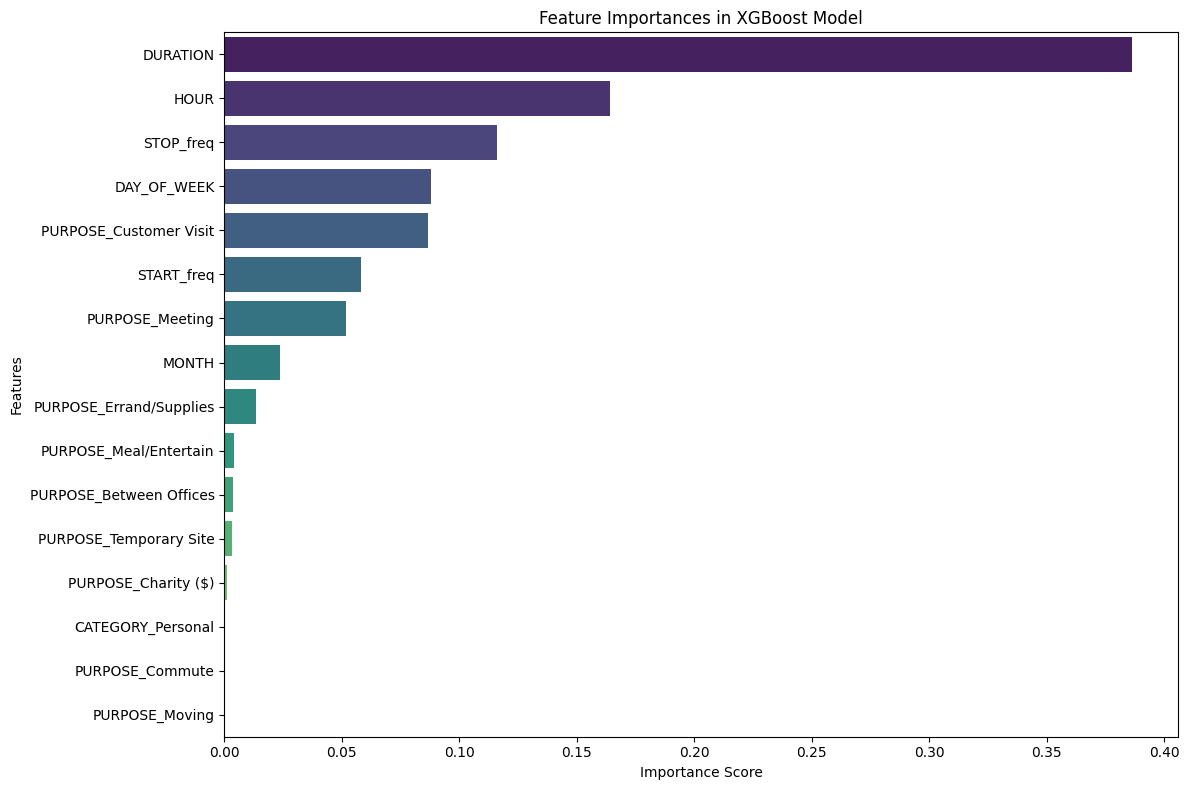

In [ ]:
# Get feature importance from the best_xgb model
importances = best_xgb.feature_importances_

# Get feature names
feature_names = X_train.columns

# Create a DataFrame for plotting
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
})

# Sort the DataFrame by importance
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Plot the feature importance
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df, palette='viridis')
plt.title('Feature Importances in XGBoost Model')
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.tight_layout()
plt.show()

This feature importance plot shows that DURATION and HOUR are the most influential features in the XGBoost model, with DURATION having the highest impact on predictions. Other important features include STOP_freq, DAY_OF_WEEK, and PURPOSE_Customer Visit, suggesting that time-related and frequency variables significantly contribute to the model’s output. Features like PURPOSE_Moving and PURPOSE_Commute have minimal influence, indicating they contribute little to the predictions. This information can guide further feature engineering or selection.

22. **Model Performance Across Features**

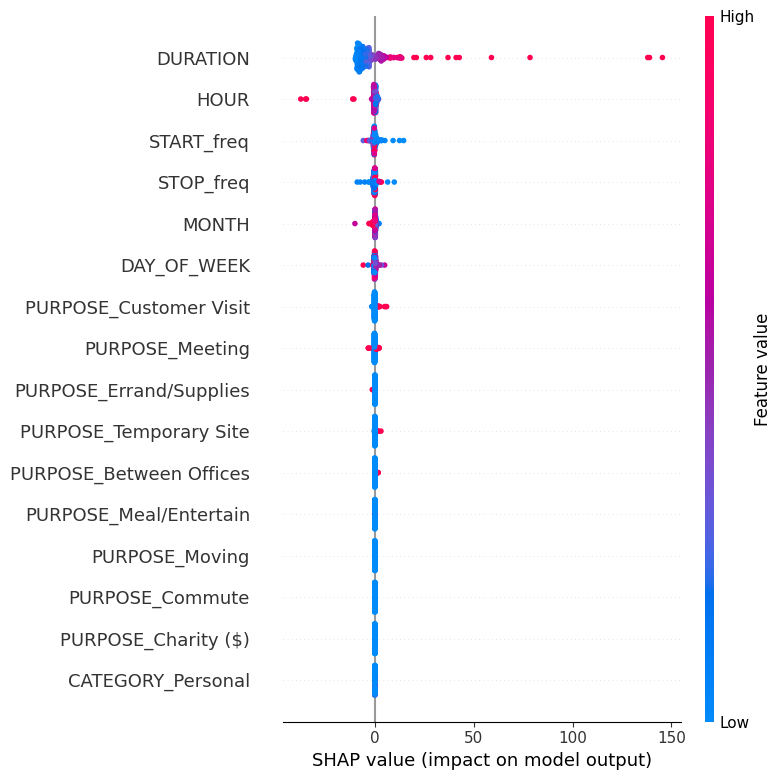

In [ ]:
# Convert all columns to float64
X_train = X_train.astype('float64')
X_test = X_test.astype('float64')

# Initialize the JavaScript visualization in notebooks
shap.initjs()

# Create a SHAP explainer
explainer = shap.Explainer(best_xgb, X_train)

# Calculate SHAP values for the test set
shap_values = explainer(X_test)

# Generate a summary plot
shap.summary_plot(shap_values, X_test)

This SHAP summary plot shows how each feature influences the model's predictions, with the impact of each feature represented by SHAP values along the x-axis.

DURATION has the strongest impact on predictions, with higher values (shown in red) significantly increasing the model output.

HOUR, START_freq, and STOP_freq are also influential, where specific values (high or low) of these features can increase or decrease the prediction.

Features like PURPOSE_Customer Visit and MONTH also affect predictions but to a lesser extent.
Blue indicates low feature values, and red indicates high values, with the color showing how each feature's level contributes to the model’s output.

This plot suggests that time and frequency-related features play a major role, while other features like CATEGORY_Personal and PURPOSE_Charity have minimal impact.